In [29]:
%matplotlib notebook

import os
import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

In [30]:
def extract_tensorboard_data(eventfile_path, keys):
    data = {}
    for event in tf.train.summary_iterator(eventfile_path):
        if not event.HasField("summary"):
            continue
        if event.step not in data:
            data[event.step] = {}
        for v in event.summary.value:
            if v.tag in keys:
                data[event.step][v.tag] = v.simple_value
    df = pd.DataFrame(data, ).T
    df.index.name = "epoch"
    return df

In [31]:
keys = ['loss', 'binary_accuracy']
keys += ['val_' + i for i in tuple(keys)]

experiment_dirs = glob.glob("/data/log/cnn/fd/large-fromCF/tuesday1/*")

data = {}
for experiment_dir in experiment_dirs:
    event_files = []
    for experiment_path in glob.glob(os.path.join(experiment_dir, "*.tfevents.*")):
        event_files.append(extract_tensorboard_data(experiment_path, keys))
    if event_files:
        data[experiment_dir] = pd.concat(event_files).sort_index()
        index = data[experiment_dir].index
        data[experiment_dir]['experiment_dir'] = pd.Series(experiment_dir, index=index)

In [32]:
df = pd.concat(list(data.values()))
df = df.reset_index(level=0, inplace=False)
df#

,epoch,binary_accuracy,loss,val_binary_accuracy,val_loss,experiment_dir
0,0,0.834769,2.669642,0.587786,3.472585,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
1,1,0.942978,2.343299,0.618321,3.540527,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
2,2,0.967741,2.146271,0.660305,3.112473,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
3,3,0.974457,1.977393,0.650763,3.095229,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
4,4,0.978935,1.808858,0.636450,3.217503,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
5,5,0.981038,1.649994,0.644084,2.964757,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
6,6,0.980088,1.510861,0.656489,2.756361,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
7,7,0.981852,1.380217,0.656489,2.771168,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
8,8,0.982463,1.267985,0.615458,3.044186,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...
9,9,0.980733,1.177054,0.627863,2.853307,/data/log/cnn/fd/large-fromCF/tuesday1/ID:912 ...


In [36]:
# for experiment_dir, data in df.groupby('experiment_dir'):
#     print(data['val_loss'].min())
g = df.groupby('experiment_dir', as_index=False)
a = g.agg('last').sort_values(by='val_loss')
# a['overfit'] = a['val_loss'] / a['loss']
# a.sort_values(by='overfit')


def extract_experiment_params(experiment_path):
    experiment_name = experiment_path.split("/")[-1]
    fields = {}
    for field in experiment_name.split(" "):
        key, value_str = field.split(":")
        try:
            fields[key] = float(value_str)
        except ValueError:
            fields[key] = value_str
    return fields
a = pd.concat([a, pd.DataFrame(a['experiment_dir'].apply(extract_experiment_params).as_matrix().tolist(), index=a.index)], axis=1)
a[list(set(a.columns.tolist()) - {'experiment_dir', 'DS', 'AC', 'LF', 'CW'})]

,binary_accuracy,KR,LR,val_loss,AR,FT,loss,BS,MO,val_binary_accuracy,PO,HE,method,DO,ID,epoch,TR
29,0.781318,0.00000,0.0005,0.562389,0.83000,None,0.574790,8.0,simple-2,0.767578,avg,0x32,head,0.0,6603.0,9,all
48,0.841350,0.00000,0.0005,0.651527,0.36000,None,0.415621,8.0,simple-2,0.687023,avg,0x32,head,0.0,9695.0,9,all
12,0.751594,0.33000,0.0005,0.681993,0.00000,None,0.603909,8.0,simple-2,0.610687,avg,0x32,head,0.0,418.0,9,all
46,0.877072,0.00000,0.0005,0.725862,0.00018,None,0.280318,8.0,simple-2,0.683594,avg,0x32,head,0.0,9535.0,9,all
5,0.747015,0.37000,0.0005,0.727695,0.00000,None,0.676144,8.0,simple-2,0.654580,avg,0x32,head,0.0,2158.0,9,all
1,0.743589,0.62000,0.0005,0.765431,0.00000,None,0.729583,8.0,simple-2,0.555344,avg,0x32,head,0.0,1320.0,9,all
2,0.811262,0.01400,0.0005,0.812325,0.00000,None,0.471430,8.0,simple-2,0.594466,avg,0x32,head,0.0,1459.0,9,all
38,0.821981,0.01100,0.0005,0.817125,0.00000,None,0.445817,8.0,simple-2,0.690840,avg,0x32,head,0.0,8193.0,9,all
36,0.751526,0.12000,0.0005,0.817176,0.00000,None,0.617553,8.0,simple-2,0.655534,avg,0x32,head,0.0,7767.0,9,all
47,0.736431,0.99000,0.0005,0.831688,0.00000,None,0.703732,8.0,simple-2,0.609733,avg,0x32,head,0.0,9539.0,9,all


In [37]:
# a = df[df['experiment_dir'].apply(lambda x: x[-3:]) == '432']
# # a['val_loss'].diff()
# a.index

<IPython.core.display.Javascript object>


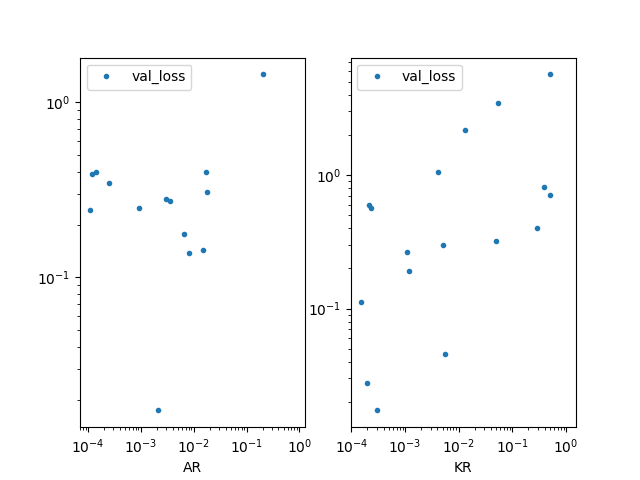

<IPython.core.display.Javascript object>


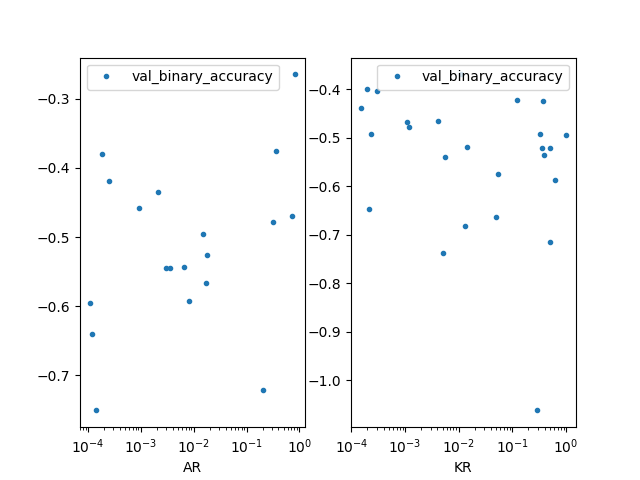

In [38]:
for metric in ['val_loss', 'val_binary_accuracy']:
    scale = None
    if metric == 'val_loss':
        scale = {'loglog': True}
    else:
        scale = {'logx': True}
    plt.figure()
    ax = plt.subplot(1,2,1)
    a[a['KR'] == 0][['AR'] + [metric]].set_index('AR').apply(np.log).plot(style='.', ax=ax, **scale)
    ax=plt.subplot(1,2,2)
    a[a['AR'] == 0][['KR'] + [metric]].set_index('KR').apply(np.log).plot(style='.', ax=ax, **scale)
